<a href="https://colab.research.google.com/github/adem99307/POM/blob/main/POM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-multilearn
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.1 MB/s eta 0:00:00


We load the data from csv files into a pandas dataframe and check its attributes.

In [2]:
 
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/train.csv'

data_raw = pd.read_csv(dataset_path)
data_raw = data_raw.sample(n=5000)
missing_mask = np.random.choice([False, True], size=data_raw.shape[0]*data_raw.shape[1], p=[0.8, 0.2])
#data_raw.values[missing_mask] = np.nan


print("Number of rows in data =",data_raw.shape[0])

print("Number of columns in data =",data_raw.shape[1])
print("\n")
print("**Sample data:**")
data_raw.head()



Mounted at /content/drive
Number of rows in data = 5000
Number of columns in data = 8


**Sample data:**


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
148104,46fd2a4bd131af05,"""\n\n """"Ten gallon Stetson"""" ./ / """"Deal me a ...",0,0,0,0,0,0
86487,e75999d3a6a5abd1,"""\n\n UNBELIEVABLE, TALKING TO A CHILD \n\n Y...",0,0,0,0,0,0
94200,fbe654d10c394fb9,ANTI LATINO RACIST! IM GONNA GET THE ACLU ON Y...,1,0,0,0,0,1
129339,b3c3395a7838e68f,Weird comment\nThe editor you responded to on ...,0,0,0,0,0,0
124212,987783e13f479662,Help!!!\n\nThe Current Squad box seems to be b...,0,0,0,0,0,0


Now we count the number of comments under each label.

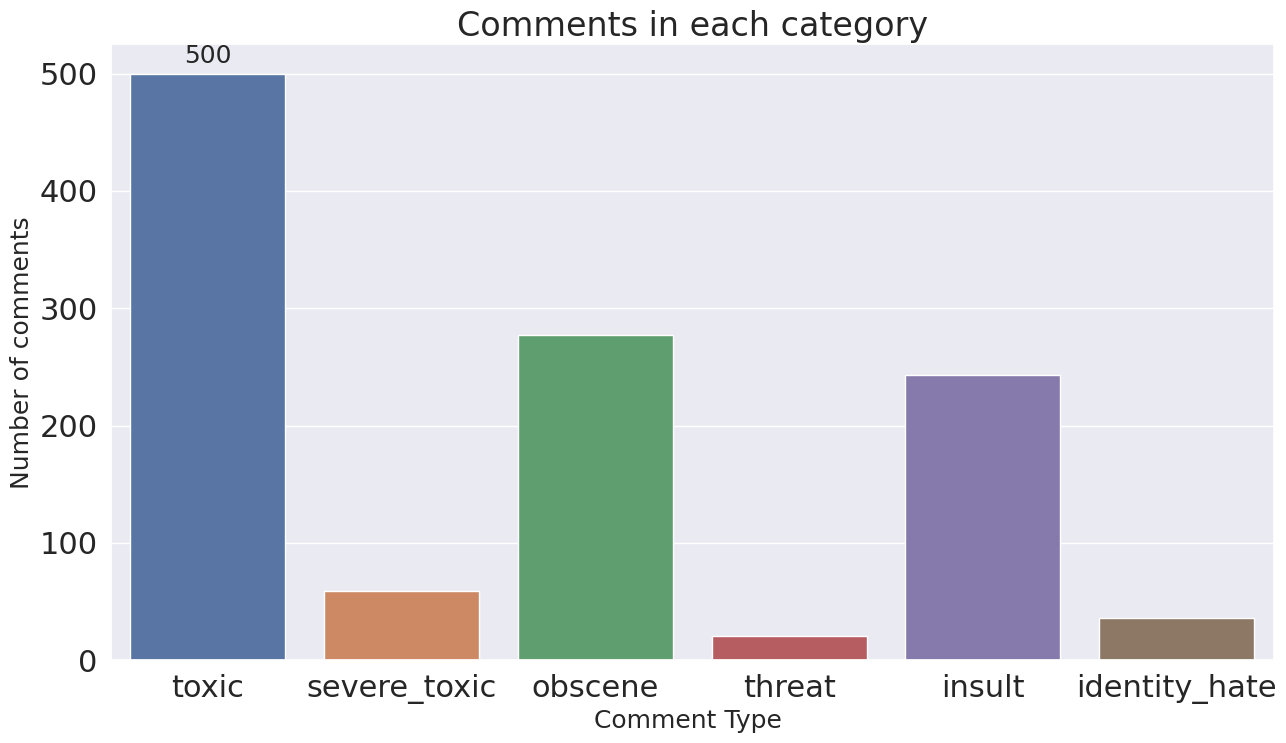

In [3]:
categories = list(data_raw.columns.values)[2:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=categories, y=data_raw.iloc[:,2:].sum().values)
plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.show()

   Counting the number of comments having multiple labels:

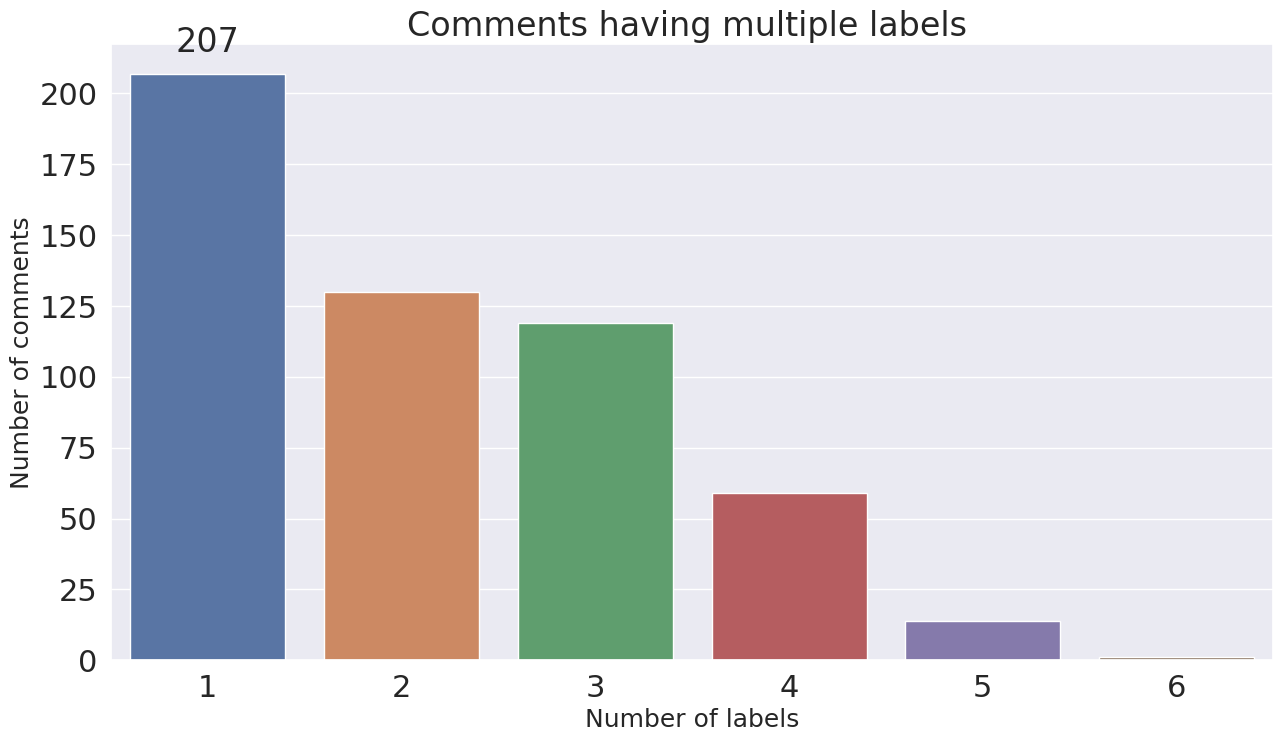

In [4]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=multiLabel_counts.index,y=multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()

**Data prepocessing**

We first convert the comments to lower-case and then use custom made functions to remove html-tags, punctuation and non-alphabetic characters from the comments.

In [5]:
#Prepocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
data = data_raw
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)

- Next we remove all the stop-words present in the comments using the default set of stop-words that can be downloaded from NLTK library. We also add few stop-words to the standard list.

- Stop words are basically a set of commonly used words in any language, not just English. The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead. 

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['comment_text'] = data['comment_text'].apply(removeStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Next we do stemming. There exist different kinds of stemming which basically transform words with roughly the same semantics to one standard form. For example, for amusing, amusement, and amused, the stem would be amus.

In [7]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['comment_text'] = data['comment_text'].apply(stemming)

**Before splitting the dataset I have to change a multi-label learning dataset** **into a partial multi-label learning dataset, so I need to introduce** **some instances that have only a partial set of labels associated with them.**

**So I will replace randomly a label or set of labels of each instance by -1 or NaN depends to the algorithm used, means** **that this label is missed**. 

After splitting the dataset into train & test sets, we want to summarize our comments and convert them into numerical vectors.
     One technique is to pick the most frequently occurring terms (words with high term frequency or tf). However, the most frequent word is a less useful metric since some words like 'this', 'a' occur very frequently across all documents.
     Hence, we also want a measure of how unique a word is i.e. how infrequently the word occurs across all documents (inverse document frequency or idf).
     So, the product of tf & idf (TF-IDF) of a word gives a product of how frequent this word is in the document multiplied by how unique the word is w.r.t. the entire corpus of documents.
     Words in the document with a high tfidf score occur frequently in the document and provide the most information about that specific document.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

#x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.30,shuffle=True)

def create_missing_labels(y, frac=0.2):
    y_missing = np.copy(y)
    n_samples, n_labels = y_missing.shape
    for i in range(n_samples):
        n_missing_labels = int(n_labels * frac)
        missing_label_indices = np.random.choice(n_labels, size=n_missing_labels, replace=False)
        y_missing[i, missing_label_indices] = -1
    return y_missing

# create missing labels for training and test data
y_train = train.drop(labels = ['id','comment_text'], axis=1)
y_test = test.drop(labels = ['id','comment_text'], axis=1)

y_train_missing = create_missing_labels(y_train.values)
y_test_missing = create_missing_labels(y_test.values)





TF-IDF is easy to compute but its disadvantage is that it does not capture position in text, semantics, co-occurrences in different documents, etc.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
cv = CountVectorizer()
X_train = cv.fit_transform(train['comment_text'])
X_test = cv.transform(test['comment_text'])


# TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(train['comment_text'])
X_test_tfidf = tfidf.transform(test['comment_text'])

 **Multi-Label Classification Techniques**:

Most traditional learning algorithms are developed for single-label classification problems. Therefore a lot of approaches in the literature transform the multi-label problem into multiple single-label problems, so that the existing single-label algorithms can be used.

**1. OneVsRest**

One-vs-Rest (OvR) is a method that can be adapted for partial multi-label learning by modifying the way the binary classifiers are trained and used during testing.

During training, when an instance has only a partial set of labels, the binary classifiers are only trained on the labels that are present in the instance. This is achieved by creating a separate binary classifier for each label that appears in the training data, and then training each classifier only on the instances that have that label.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


#convert your label data to a binary format using MultiLabelBinarizer from the sklearn.preprocessing module.
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])


# Training logistic regression model on train data
LogReg_pipeline.fit(X_train_tfidf,y_train)    
# calculating test accuracy
ovr_y_pred = LogReg_pipeline.predict(X_test_tfidf)
print('Test accuracy is {}'.format(accuracy_score(y_test, ovr_y_pred)))
print("\n")



Test accuracy is 0.9013333333333333




**2. Binary Relevance**

Binary relevance is a popular method for multi-label classification that can be adapted for partial multi-label learning. Here's how:

During training, when an instance has only a partial set of labels, the binary relevance method can be adapted by training only on the labels that are present in the instance. This can be done by selecting only the columns of the label matrix that correspond to the labels present in the instance and training a binary classifier for each of them. For example, if an instance has labels A and B, then we would train a binary classifier for A and another binary classifier for B.

In [27]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())# train
classifier.fit(X_train_tfidf, y_train)# predict
br_y_pred = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,br_y_pred))


Accuracy =  0.788


**3. Classifier Chains:**

Classifier Chains (CC) is another popular method for multi-label classification that can be adapted for partial multi-label learning. Here's how:

During training, when an instance has only a partial set of labels, the Classifier Chains method can be adapted by modifying the label matrix to include a dummy label for each missing label. This means that the label matrix is extended to include all possible labels in the dataset, with a binary value of 0 for the missing labels in the partial set of labels. For example, if an instance has labels A and B, and the dataset has labels A, B, C, and D, then the label matrix would be extended to include a binary column for label C and a binary column for label D, with values of 0 for both columns for this particular instance.


In [28]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression# initialize classifier chains multi-label classifier
from sklearn.metrics import accuracy_score

classifier = ClassifierChain(LogisticRegression())# Training logistic regression model on train data
classifier.fit(X_train_tfidf, y_train) #training 
cc_y_pred = classifier.predict(X_test_tfidf) #predict
print("Accuracy = ",accuracy_score(y_test,cc_y_pred)) #accuracy
print("\n")

Accuracy =  0.906




**4. Label Powerset:**

Label Powerset (LP) is another popular method for multi-label classification that can be adapted for partial multi-label learning. Here's how:

During training, when an instance has only a partial set of labels, the Label Powerset method can be adapted by modifying the label matrix to include a dummy label for each missing label. This means that the label matrix is extended to include all possible label combinations in the dataset, with a binary value of 0 for the missing labels in the partial set of labels. For example, if an instance has labels A and B, and the dataset has labels A, B, C, and D, then the label matrix would be extended to include binary columns for the label combinations AB, AC, AD, BC, BD, and CD, with values of 0 for all columns except for the AB column, which would have a value of 1 for this particular instance.

In [29]:
from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())# train
classifier.fit(X_train_tfidf, y_train)# predict
lp_y_pred = classifier.predict(X_test_tfidf)# accuracy
print("Accuracy = ",accuracy_score(y_test,lp_y_pred))
print("\n")

Accuracy =  0.902







**5. Partial-Label Learning with Neural Networks (PLNN)(deep learning):**

Partial-Label Learning with Neural Networks (PLNN) can be adapted for partial multi-label learning by modifying the mask input to include multiple binary vectors, one for each label. Specifically, instead of having a single mask input with the same shape as the number of labels, we can have a mask input with the shape (num_samples, num_labels), where each element is either 0 or 1 to indicate whether the corresponding label is present or not. In this way, we can handle partial labels for each label independently.

In [33]:
from keras.models import Model
from keras.layers import Input, Dense, Masking, Concatenate
from keras.optimizers import Adam
import numpy as np

def build_plnn(num_features, num_labels):
    # Input layer
    input_layer = Input(shape=(num_features,))
    
    # Masking layer to handle partial labels
    mask_input = Input(shape=(num_labels,))
    mask_layer = Masking(mask_value=0)(mask_input)
    masked_input = Concatenate()([input_layer, mask_layer])
    
    # Hidden layers
    hidden_layer_1 = Dense(128, activation='relu')(masked_input)
    hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
    
    # Output layer
    output_layer = Dense(num_labels, activation='sigmoid')(hidden_layer_2)
    
    # Model
    model = Model(inputs=[input_layer, mask_input], outputs=output_layer)
    
    # Compile model
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

num_features = X_train_tfidf.shape[1]
num_labels = y_train.shape[1]

X_train_array = X_train_tfidf.toarray()
y_train_array = np.array(y_train)
X_test_array = X_test_tfidf.toarray()
y_test_array = np.array(y_test)

plnn_model = build_plnn(num_features=num_features, num_labels=num_labels)  
plnn_model.fit(x=[X_train_array, y_train_array], y=y_train_array)
plnn_predict = plnn_model.predict([X_test_array, y_test_array])
print(plnn_predict.shape)
print(y_test.shape)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


47/47 [==============================] - 0s 5ms/step
(1500, 6)
(1500, 6)


In [40]:
br_accuracy = accuracy_score(y_test, br_y_pred)
br_hamming_loss = hamming_loss(y_test, br_y_pred)
br_f1_score = f1_score(y_test, br_y_pred, average='micro')
print(br_accuracy)
lp_accuracy = accuracy_score(y_test, lp_y_pred)
lp_hamming_loss = hamming_loss(y_test, lp_y_pred)
lp_f1_score = f1_score(y_test, lp_y_pred, average='micro')
print(lp_accuracy)

cc_accuracy = accuracy_score(y_test, cc_y_pred)
cc_hamming_loss = hamming_loss(y_test, cc_y_pred)
cc_f1_score = f1_score(y_test, cc_y_pred, average='micro')
print(cc_accuracy)


ovr_accuracy = accuracy_score(y_test, ovr_y_pred)
ovr_hamming_loss = hamming_loss(y_test, ovr_y_pred)
ovr_f1_score = f1_score(y_test, ovr_y_pred, average='micro')
print(ovr_accuracy)


plnn_predict = np.nan_to_num(plnn_predict)

plnn_accuracy = accuracy_score(y_test, plnn_predict)
plnn_hamming_loss = hamming_loss(y_test, plnn_predict)
plnn_f1_score = f1_score(y_test, plnn_predict, average='micro')

print(plnn_accuracy)


0.788
0.902
0.906
0.9013333333333333
0.898


**Comparaison:**

To compare the performance of these algorithms, we can use various evaluation metrics such as accuracy, F1 score, and Hamming loss.

Accuracy is a widely used metric in classification problems, and it measures the percentage of correctly predicted labels. However, accuracy may not be the most appropriate metric for partial labeling problems, as it does not take into account the partial nature of the labels.

F1 score is another commonly used metric that considers both precision and recall. It is especially useful when there is an imbalance in the distribution of labels, as it takes into account the number of true positives, false positives, and false negatives.

Hamming loss is a metric that considers the difference between the predicted labels and the true labels. It measures the percentage of labels that are incorrectly predicted, normalized by the total number of labels.



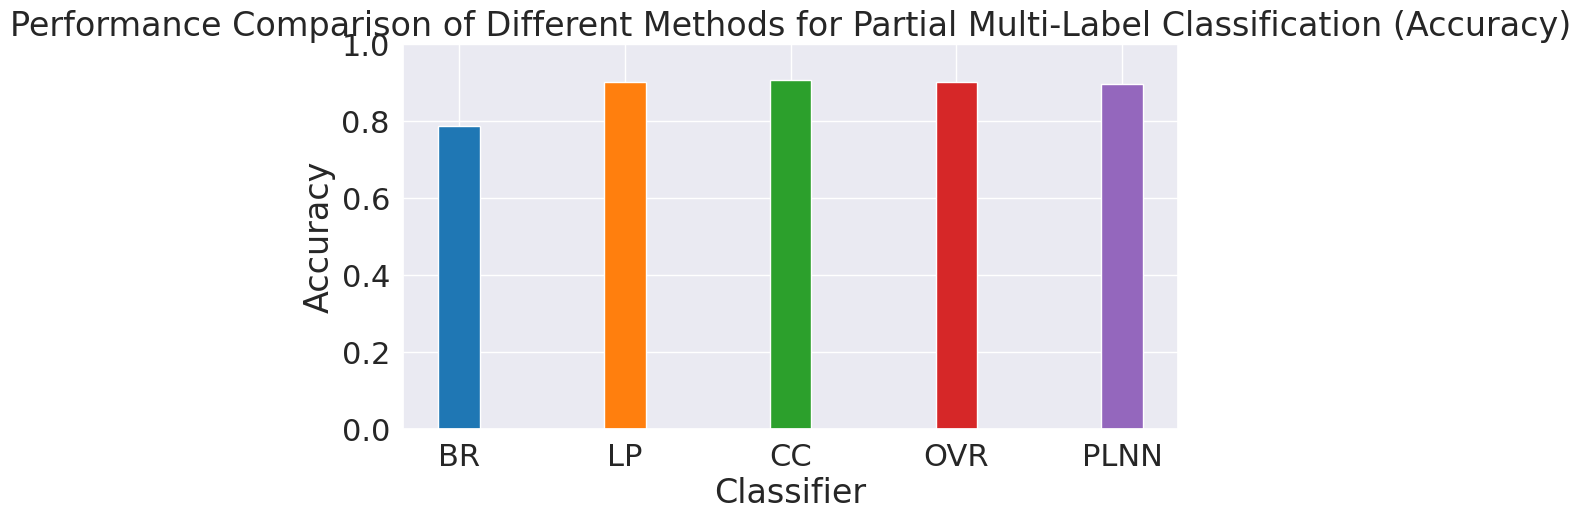

In [34]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

br_accuracy = accuracy_score(y_test, br_y_pred)
br_hamming_loss = hamming_loss(y_test, br_y_pred)
br_f1_score = f1_score(y_test, br_y_pred, average='micro')

lp_accuracy = accuracy_score(y_test, lp_y_pred)
lp_hamming_loss = hamming_loss(y_test, lp_y_pred)
lp_f1_score = f1_score(y_test, lp_y_pred, average='micro')

cc_accuracy = accuracy_score(y_test, cc_y_pred)
cc_hamming_loss = hamming_loss(y_test, cc_y_pred)
cc_f1_score = f1_score(y_test, cc_y_pred, average='micro')

ovr_accuracy = accuracy_score(y_test, ovr_y_pred)
ovr_hamming_loss = hamming_loss(y_test, ovr_y_pred)
ovr_f1_score = f1_score(y_test, ovr_y_pred, average='micro')

plnn_predict = np.nan_to_num(plnn_predict)

plnn_accuracy = accuracy_score(y_test, plnn_predict)
plnn_hamming_loss = hamming_loss(y_test, plnn_predict)
plnn_f1_score = f1_score(y_test, plnn_predict, average='micro')

# Create a list of the evaluation metrics for each classifier
accuracies = [br_accuracy, lp_accuracy, cc_accuracy, ovr_accuracy, plnn_accuracy]
hamming_losses = [br_hamming_loss, lp_hamming_loss, cc_hamming_loss, ovr_hamming_loss, plnn_accuracy]
f1_scores = [br_f1_score, lp_f1_score, cc_f1_score, ovr_f1_score, plnn_accuracy]

# Set the labels for the classifiers
labels = ['BR', 'LP', 'CC', 'OVR', 'PLNN']

# Set the colors for the bars
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Set the width of the bars
width = 0.25

# Set the positions of the bars on the x-axis
x_positions = np.arange(len(labels))

# Plot the bar chart for accuracy

plt.figure(figsize=(10, 5))
plt.bar(x_positions, accuracies, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (Accuracy)')
plt.ylim([0, 1])
plt.show()
print("\n")



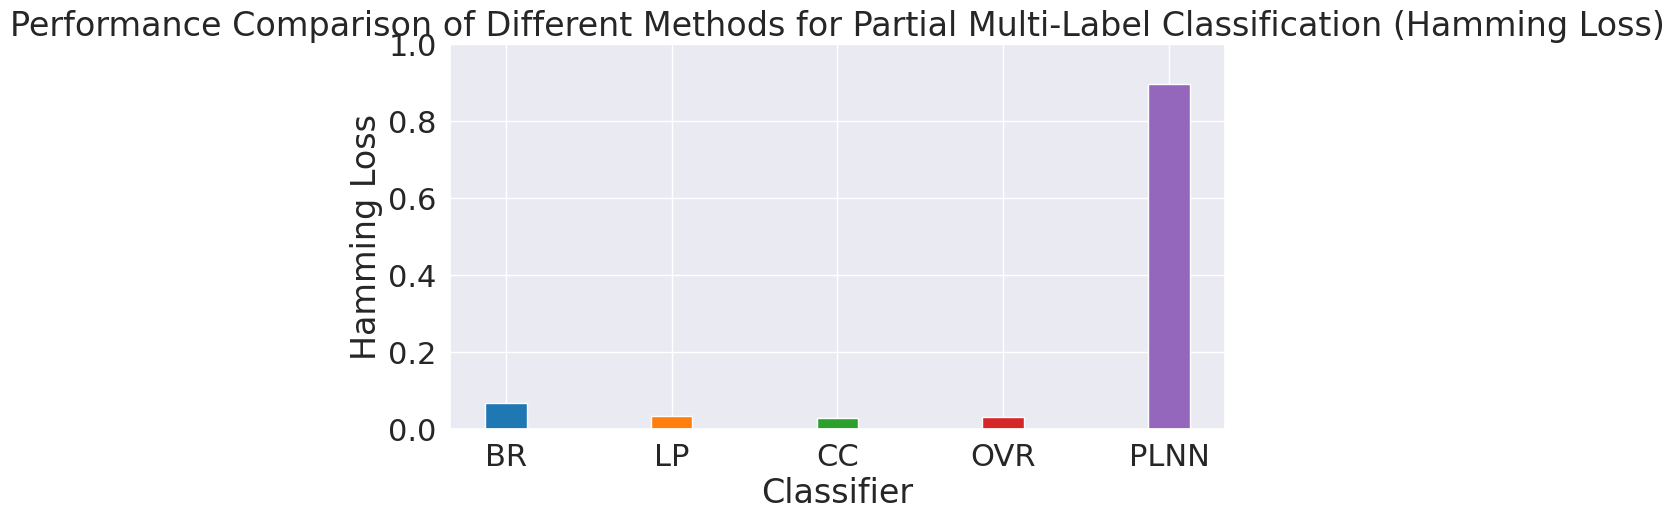

In [35]:
# Plot the bar chart for hamming loss
plt.figure(figsize=(10, 5))
plt.bar(x_positions, hamming_losses, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('Hamming Loss')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (Hamming Loss)')
plt.ylim([0, 1])
plt.show()
print("\n")


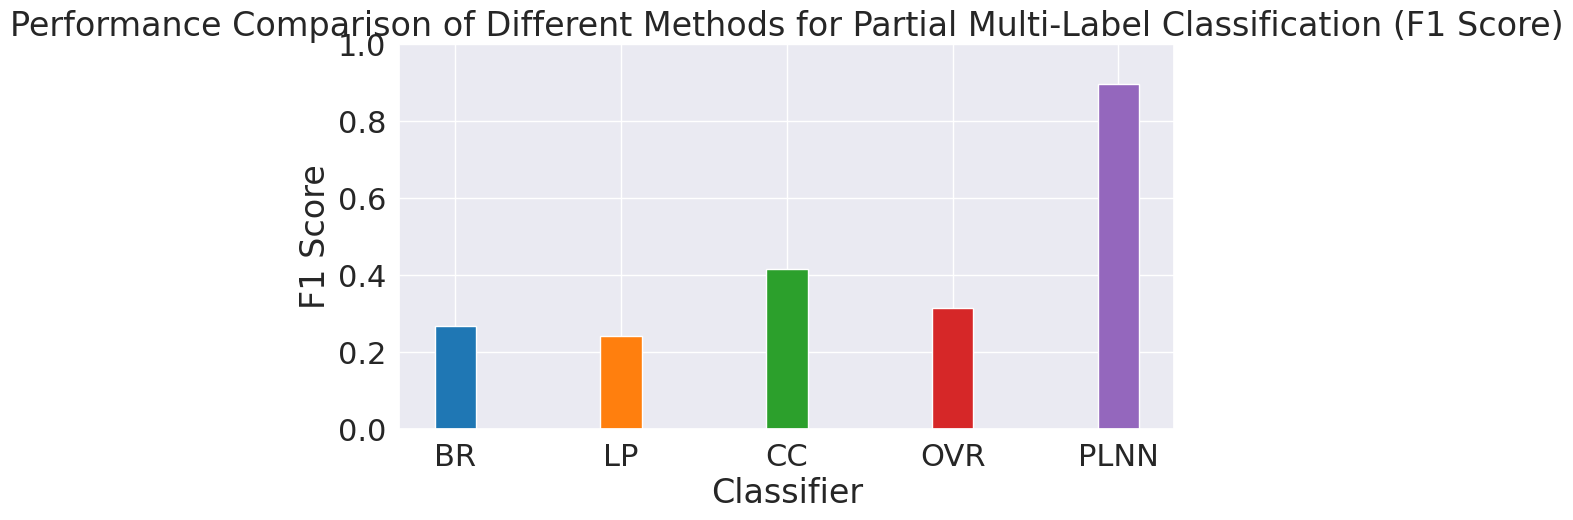

In [36]:
# Plot the bar chart for F1 score
plt.figure(figsize=(10, 5))
plt.bar(x_positions, f1_scores, width, color=colors)
plt.xticks(x_positions, labels)
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('Performance Comparison of Different Methods for Partial Multi-Label Classification (F1 Score)')
plt.ylim([0, 1])
plt.show()

**We see clearly that the Classifier Chain method is the best in term of performance compared with others.**